In [35]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

Let's take a look at the training data for the lunar dataset. In addition to the data itself, we include a catalog that will tell you which events happen when in the data. The catalog includes the name of the file, the absolute time, the relative time in seconds (relative to the start of the file), the event ID (evid), and the type of moonquake. The types of moonquakes include impacts, deep moonquakes, and shallow moonquakes. You do not have to worry about predicting the type of moonquakes, that's just fun information for you to know! 

**Note**: For your prediction, feel free to include either the absolute time or relative time, just make sure to mark it using the same header in the CSV file so we can easily score it!

In [36]:
cat_directory = './data/lunar/test/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid
0,xa.s16.00.mhz.1977-06-02HR00_evid00255,1977-06-02T00:08:27.000000,0,evid00255


## Select a detection

Let's pick the first seismic event in the catalog and let's take a look at the absolute time data. The way we show it here is by using pandas `.iloc` and datetime `.strptime`. We are going to keep the format shown in the absolute time header, which is `'%Y-%m-%dT%H:%M:%S.%f'`

In [37]:
row = cat.iloc[0]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
arrival_time

datetime.datetime(1977, 6, 2, 0, 8, 27)

In [38]:
# If we want the value of relative time, we don't need to use datetime
arrival_time_rel = row['time_rel(sec)']
arrival_time_rel

0

In [39]:
# Let's also get the name of the file
test_filename = row.filename
test_filename

'xa.s16.00.mhz.1977-06-02HR00_evid00255'

## Read the CSV file corresponding to that detection

We will now find the csv data file corresponding to that time and plot it!

In [40]:
data_directory = './data/lunar/training/data/S16_GradeA/'
csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)
data_cat

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1977-06-02T00:00:00.164000,0.000000,-2.257746e-15
1,1977-06-02T00:00:00.314943,0.150943,-2.949132e-15
2,1977-06-02T00:00:00.465887,0.301887,-3.265891e-15
3,1977-06-02T00:00:00.616830,0.452830,-3.138921e-15
4,1977-06-02T00:00:00.767774,0.603774,-2.704786e-15
...,...,...,...
572438,1977-06-03T00:00:05.899849,86405.735849,-5.458457e-16
572439,1977-06-03T00:00:06.050792,86405.886792,-7.807909e-16
572440,1977-06-03T00:00:06.201736,86406.037736,-9.130305e-16
572441,1977-06-03T00:00:06.352679,86406.188679,-1.236820e-15


CSV Data Sample: [-2.25774609e-15 -2.94913246e-15 -3.26589128e-15 -3.13892052e-15
 -2.70478551e-15 -2.18710387e-15 -1.74400912e-15 -1.39212399e-15
 -1.04678198e-15 -6.27119043e-16]


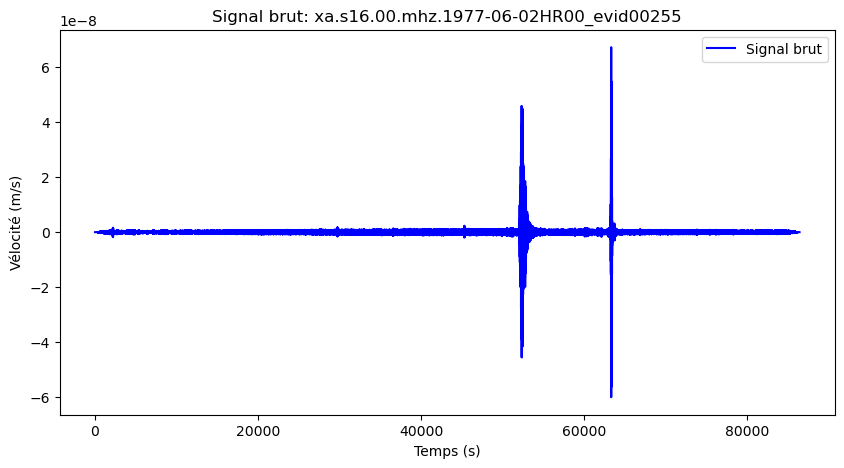

Average quiet amplitude: 2.9984701300365475e-10
Threshold for peak detection: 2.9984701300365476e-09
Arrival time (relative): 52048.301886792455


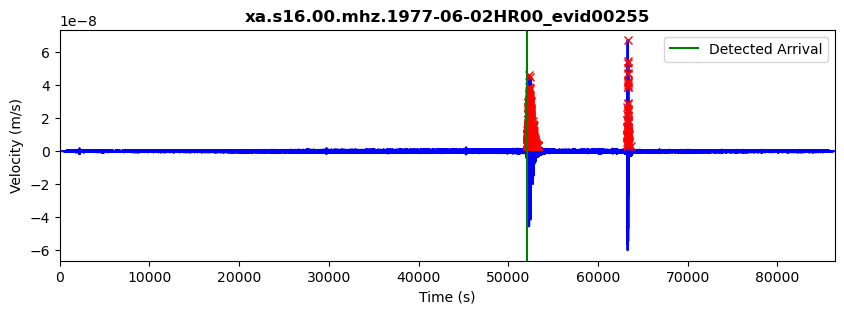

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from datetime import datetime

# Lire les données
csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)

# Lire les temps relatifs et les vitesses
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Vérifiez si les données sont correctement chargées
print("CSV Data Sample:", csv_data[:10])  # Affichez les 10 premières valeurs pour vérifier

# Tracer le signal brut
plt.figure(figsize=(10, 5))
plt.plot(csv_times, csv_data, label='Signal brut', color='blue')
plt.xlabel('Temps (s)')
plt.ylabel('Vélocité (m/s)')
plt.title(f'Signal brut: {test_filename}')
plt.legend()
plt.show()

# Calculez la moyenne de l'amplitude dans une zone calme (ajustez les indices)
quiet_segment = csv_data  
average_quiet_amplitude = np.mean(np.abs(quiet_segment))
print("Average quiet amplitude:", average_quiet_amplitude)

# Calculez un seuil basé sur la différence relative
threshold = average_quiet_amplitude * 10  # Vous pouvez ajuster le facteur (10 ici)
print("Threshold for peak detection:", threshold)

# Détecter les pics dans le signal avec le seuil
peaks, properties = find_peaks(csv_data, height=threshold)

# Si des pics sont trouvés, obtenir le premier
if len(peaks) > 0:
    first_peak_index = peaks[0]
    arrival_time_rel = csv_times[first_peak_index]
    print("Arrival time (relative):", arrival_time_rel)  # Vérifiez la valeur
else:
    print("No peaks found in the signal.")
    arrival_time_rel = None  # Définir sur None ou gérer en conséquence

# Tracer le signal avec les pics détectés
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(csv_times, csv_data, label='Signal', color='blue')

# Marquer les pics détectés
if len(peaks) > 0:
    ax.plot(csv_times[peaks], csv_data[peaks], "x", color='red', label='Detected Peaks')

# Rendre le graphique agréable
ax.set_xlim([min(csv_times), max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')
ax.legend()

# Tracer la ligne d'arrivée si détectée
if arrival_time_rel is not None:
    arrival_line = ax.axvline(x=arrival_time_rel, c='green', label='Detected Arrival')
    ax.legend(handles=[arrival_line])

# Afficher le graphique
plt.show()


In [42]:
cat['time_rel(sec)'] = arrival_time_rel
cat
cat.to_csv(cat_file, index=False)

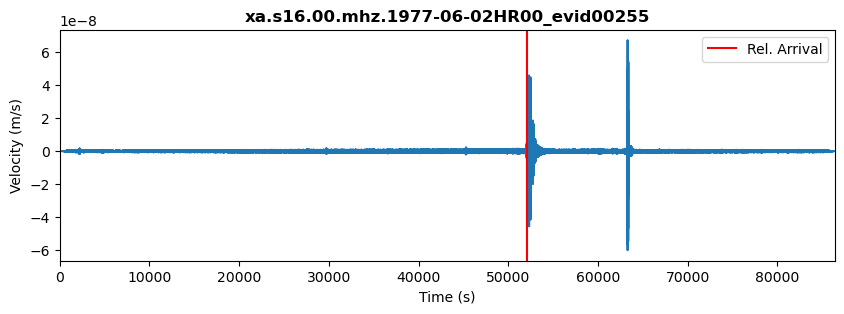

In [43]:
# Read in time steps and velocities
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])

What if you wanted to plot in absolute time instead? The operations are very similar, just with a little extra datetime. It takes a bit longer, so we recommend working in relative time to start with!

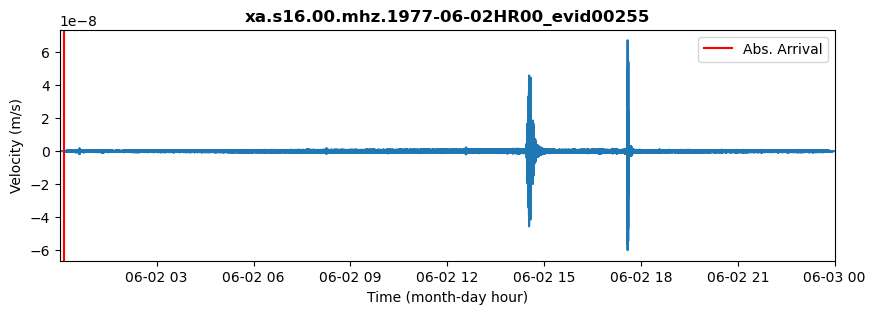

In [44]:
# Read in time steps and velocities
csv_times_dt = []
for absval_str in data_cat['time_abs(%Y-%m-%dT%H:%M:%S.%f)'].values:
    csv_times_dt.append(datetime.strptime(absval_str,'%Y-%m-%dT%H:%M:%S.%f'))

csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times_dt,csv_data)

# Make the plot pretty
ax.set_xlim((np.min(csv_times_dt),np.max(csv_times_dt)))
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (month-day hour)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time, c='red', label='Abs. Arrival')
ax.legend(handles=[arrival_line])

### Alternatively: read the miniseed file corresponding to that detection

Same procedure as above, just using the miniseed file. 

In [45]:
data_directory = './data/lunar/training/data/S16_GradeA/'
mseed_file = f'{data_directory}{test_filename}.mseed'
st = read(mseed_file)
st

1 Trace(s) in Stream:
XA.S16.00.MHZ | 1977-06-02T00:00:00.164000Z - 1977-06-03T00:00:06.503623Z | 6.6 Hz, 572443 samples

In [46]:
# The stream file also contains some useful header information
st[0].stats

         network: XA
         station: S16
        location: 00
         channel: MHZ
       starttime: 1977-06-02T00:00:00.164000Z
         endtime: 1977-06-03T00:00:06.503623Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572443
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

In [49]:
# This is how you get the data and the time, which is in seconds
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data



### Plot the trace and mark the arrival! 

Use a similar method to plot the miniseed data and seismic arrival.

Text(0.5, 1.0, 'xa.s16.00.mhz.1977-06-02HR00_evid00255')

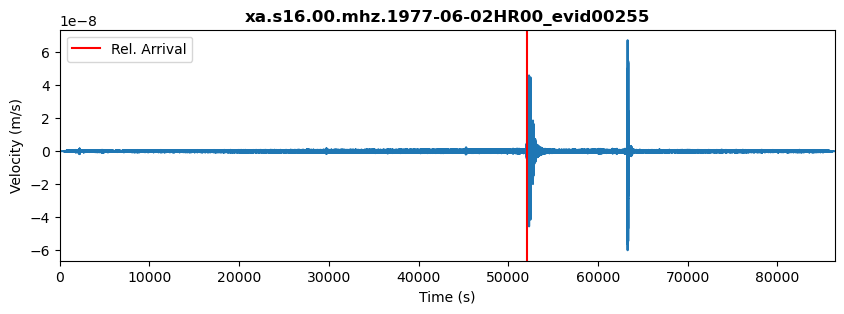

In [51]:
# Initialize figure
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(tr_times,tr_data)

# Mark detection
ax.axvline(x = arrival_time_rel, color='red',label='Rel. Arrival')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

## Let's filter the trace

Sometimes, it's useful to filter the trace to bring out particular frequencies. This will change the shape of the data and make it easier to see certain parts of the signal. In this example, we will filter the data using a bandpass filter between 0.01 Hz to 0.5 Hz. 

In [56]:
# Set the minimum frequency
minfreq = 0.5
maxfreq = 1.0

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

In [57]:
# To better see the patterns, we will create a spectrogram using the scipy function
# It requires the sampling rate, which we can get from the miniseed header as shown a few cells above
from scipy import signal
from matplotlib import cm
f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

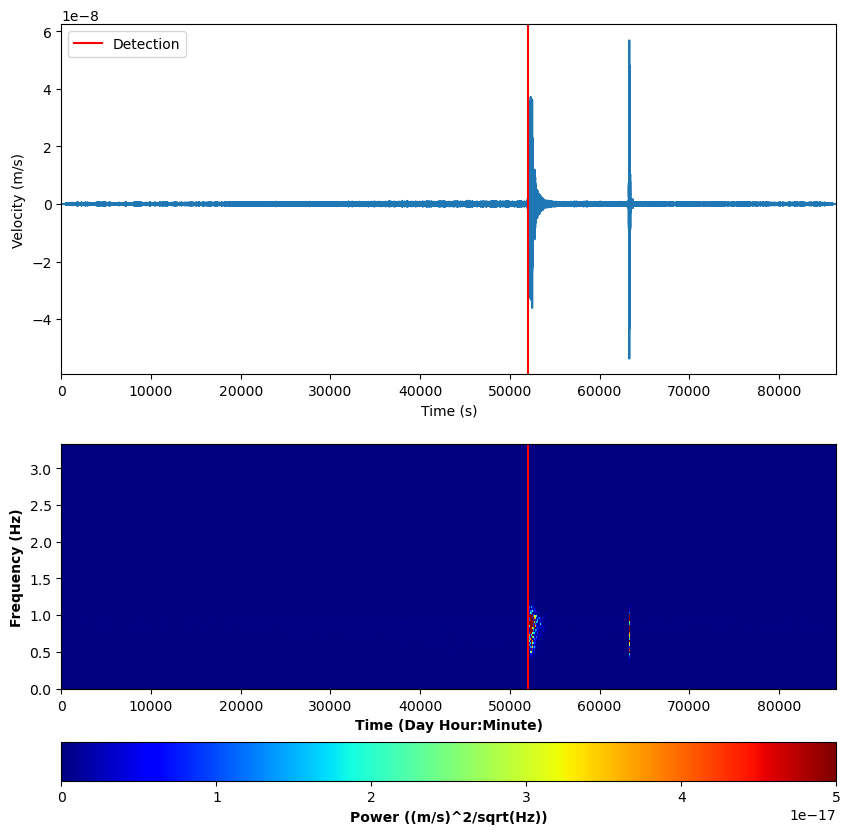

In [60]:
# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(tr_times_filt,tr_data_filt)

# Mark detection
ax.axvline(x = arrival_time_rel, color='red',label='Detection')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival_time_rel, c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

# Sample short-term average / long-term average (STA/LTA) detection algorithm

A STA/LTA algorithm moves two time windows of two lengths (one short, one long) across the seismic data. The algorithm calculates the average amplitude in both windows, and calculates the ratio between them. If the data contains an earthquake, then the short-term window containing the earthquake will be much larger than the long-term window -- resulting in a detection. 

Text(0, 0.5, 'Characteristic function')

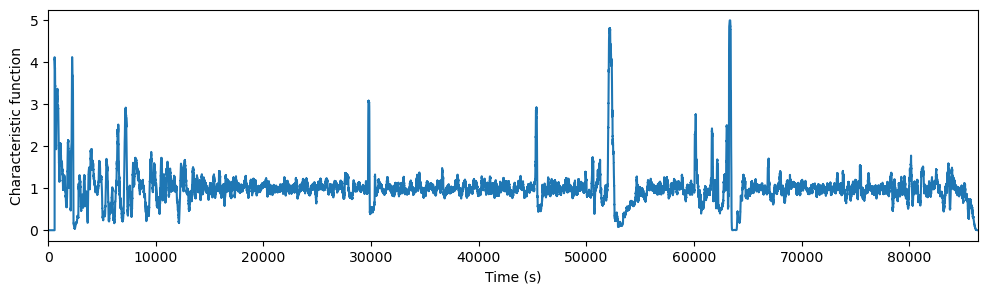

In [61]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

# Sampling frequency of our trace
df = tr.stats.sampling_rate

# How long should the short-term and long-term window be, in seconds?
sta_len = 120
lta_len = 600

# Run Obspy's STA/LTA to obtain a characteristic function
# This function basically calculates the ratio of amplitude between the short-term 
# and long-term windows, moving consecutively in time across the data
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))

# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')

Next, we define the values of the characteristic function (i.e. amplitude ratio between short-term and long-term windows) where we flag a seismic detection. These values are called triggers. There are two types of triggers -- "on" and "off", defined as follows:

1. "on" : If the characteristic function is above this value, then a seismic event begins. 
2. "off" : If the characteristic function falls below this value (after an "on" trigger), than a seismic event ends. 

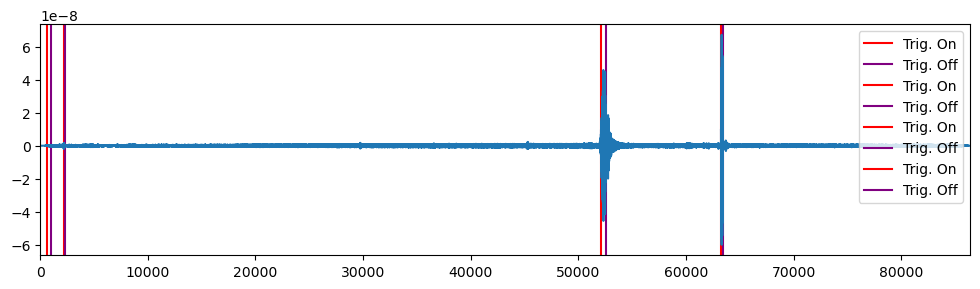

In [62]:
# Play around with the on and off triggers, based on values in the characteristic function
thr_on = 4
thr_off = 1.5
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
# The first column contains the indices where the trigger is turned "on". 
# The second column contains the indices where the trigger is turned "off".

# Plot on and off triggers
fig,ax = plt.subplots(1,1,figsize=(12,3))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
    ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')

# Plot seismogram
ax.plot(tr_times,tr_data)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.legend()